In [ ]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 7.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from math import sqrt

from pandas.plotting import autocorrelation_plot
from pandas import DataFrame
from pandas import concat

from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import boxcox

import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from matplotlib import colors

import pmdarima as pm
from pmdarima.model_selection import train_test_split
from pmdarima.arima import auto_arima

## Loading Data

In [ ]:
df = pd.read_csv("Electric_Production.csv")
df.rename(columns={"IPG2211A2N":"Energy","DATE":"Date"},inplace=True)

df

,Date,Energy
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151
...,...,...
392,9/1/2017,98.6154
393,10/1/2017,93.6137
394,11/1/2017,97.3359
395,12/1/2017,114.7212


In [ ]:
df['Date'] = pd.to_datetime(df['Date'],infer_datetime_format=True)
df = df.set_index(['Date'])
d=df
df

,Energy
Date,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151
...,...
2017-09-01,98.6154
2017-10-01,93.6137
2017-11-01,97.3359


Rolling Statistics


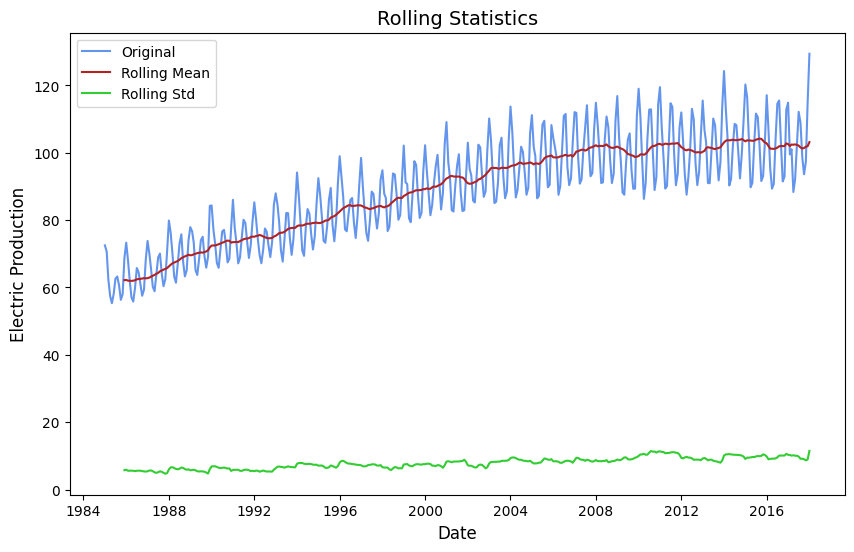

In [ ]:
rolling_mean = df.rolling(window=12).mean()
rolling_std = df.rolling(window=12).std()

plt.figure(figsize = (10,6))

plt.plot(df, color='cornflowerblue', label='Original')

plt.plot(rolling_mean, color='firebrick', label='Rolling Mean')
plt.plot(rolling_std, color='limegreen', label='Rolling Std')

plt.xlabel('Date', size = 12)
plt.ylabel('Electric Production', size  = 12)
plt.legend(loc = 'upper left')
plt.title('Rolling Statistics', size = 14)
plt.show()

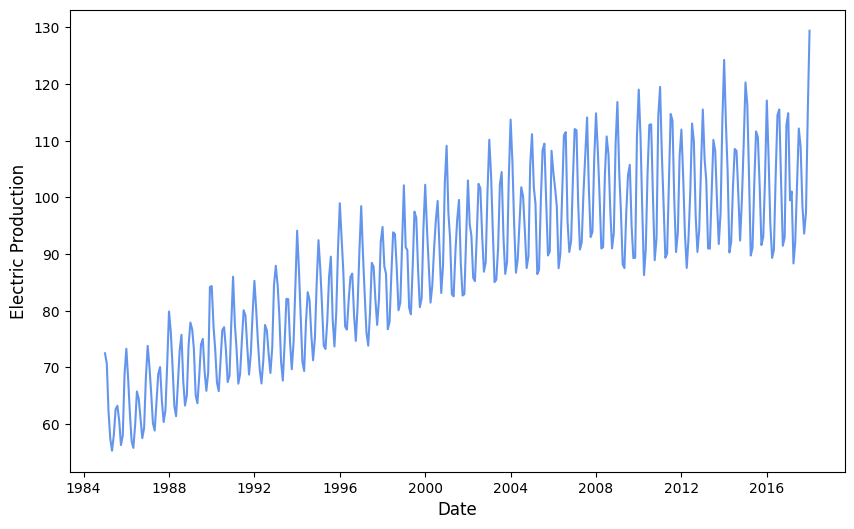

In [ ]:
plt.figure(figsize = (10,6))
plt.plot(df['Energy'], color = 'cornflowerblue')
plt.xlabel('Date', size = 12)
plt.ylabel('Electric Production', size = 12)
plt.show()

**Inference**: We can observe a **upward trend** in the energy production over the period of time

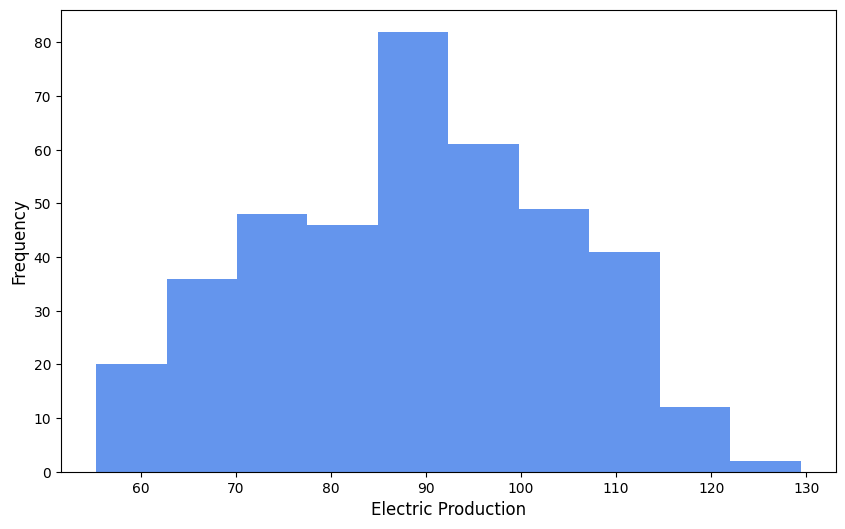

In [ ]:
plt.figure(figsize = (10,6))
plt.hist(df['Energy'], color = 'cornflowerblue')
plt.xlabel('Electric Production', size = 12)
plt.ylabel('Frequency', size = 12)
plt.show()

In [ ]:
print("Data Shape: ",df.shape)
value_1 = df[0:199]
value_2 = df[200:397]

Data Shape:  (397, 1)


Mean of data

In [ ]:
print("Mean of value_1: ",round(value_1.mean()[0],3))
print("Mean of value_2: ",round(value_2.mean()[0],3))

Mean of value_1:  77.497
Mean of value_2:  100.258


Variance of data

In [ ]:
print("Variance of value_1: ",round(value_1.var()[0],3))
print("Variance of value_2: ",round(value_2.var()[0],3))

Variance of value_1:  123.226
Variance of value_2:  91.677


**Augmented Dickey-Fuller Test**

Augmented Dickey-Fuller Test is a common statistical test used to test whether a given time series is stationary or not. We can achieve this by defining the null and alternate hypothesis.

Null Hypothesis: Time Series is non-stationary. It gives a time-dependent trend.

Alternate Hypothesis: Time Series is stationary. In another term, the series doesn’t depend on time.

ADF or t Statistic < critical values: Reject the null hypothesis, time series is stationary.
ADF or t Statistic > critical values: Failed to reject the null hypothesis, time series is non-stationary.

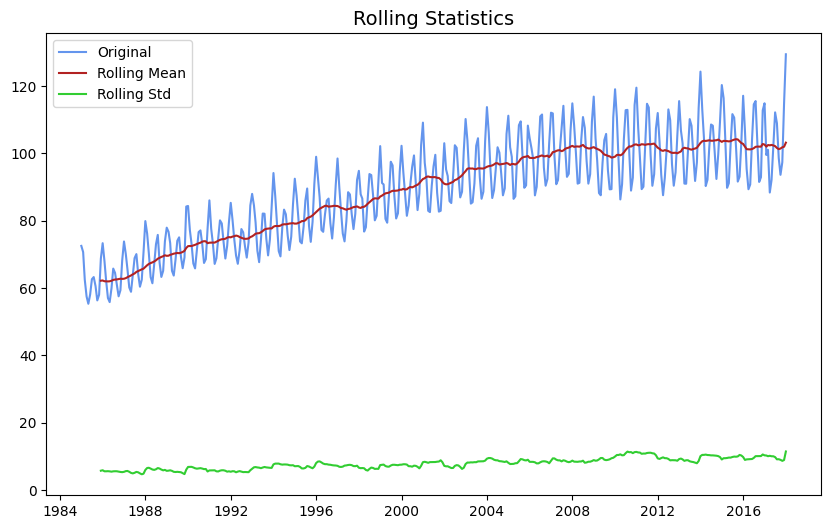


ADF Statistic: -2.257
p-value: 0.186

Critical Values:
1% -3.448
5% -2.869
10% -2.571

Failed to reject null hypothesis, time series is non-stationary.


In [ ]:
def adfuller_test(ts, window = 12):

    movingAverage = ts.rolling(window).mean()
    movingSTD = ts.rolling(window).std()

    plt.figure(figsize = (10,6))
    orig = plt.plot(ts, color='cornflowerblue',
                    label='Original')
    mean = plt.plot(movingAverage, color='firebrick',
                    label='Rolling Mean')
    std = plt.plot(movingSTD, color='limegreen',
                   label='Rolling Std')
    plt.legend(loc = 'upper left')
    plt.title('Rolling Statistics', size = 14)
    plt.show(block=False)

    adf = adfuller(ts, autolag='AIC')

    print('\nADF Statistic: {}'.format(round(adf[0],3)))
    print('p-value: {}'.format(round(adf[1],3)))

    print('\nCritical Values:')

    for key, ts in adf[4].items():
         print(key,round(ts,3))

    if adf[0] > adf[4]["5%"]:
        print ("\nFailed to reject null hypothesis, time series is non-stationary.")
    else:
        print ("\nReject null hypothesis, time series is stationary.")

adfuller_test(df, window = 12)

The p-value is obtained is greater than significance level of 0.05 and the ADF statistic is higher than any of the critical values.

 So, the time series is in fact non-stationary.

# Converting Data to Stationary


**Logarithmic Transformation with Box-Cox**

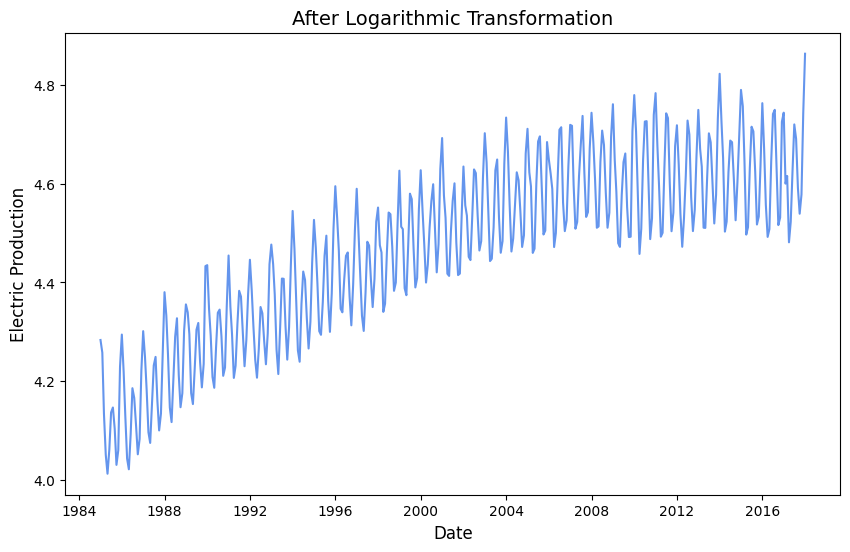

In [ ]:
df_log_scaled = df
df_log_scaled['Energy'] = boxcox(df_log_scaled['Energy'], lmbda=0.0)

plt.figure(figsize = (10,6))
plt.plot(df_log_scaled, color = 'cornflowerblue')
plt.xlabel('Date', size = 12)
plt.ylabel('Electric Production', size = 12)
plt.title("After Logarithmic Transformation", size = 14)
plt.show()

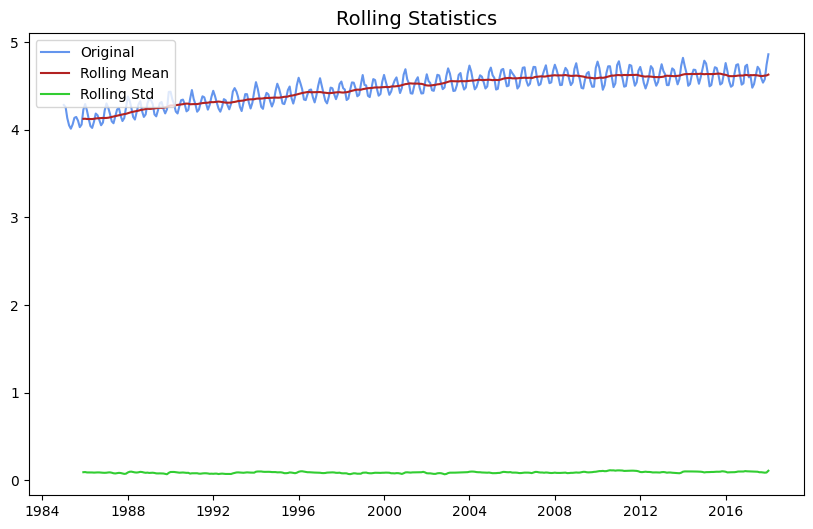


ADF Statistic: -3.145
p-value: 0.023

Critical Values:
1% -3.448
5% -2.869
10% -2.571

Reject null hypothesis, time series is stationary.


In [ ]:
adfuller_test(df,window = 12)

# Removing Trend with Moving Average

An identified trend can be modeled. Once modeled, it can be removed from the time series dataset. This is called detrending the time series.If a dataset does not have a trend or we successfully remove the trend, the dataset is said to be trend stationary.

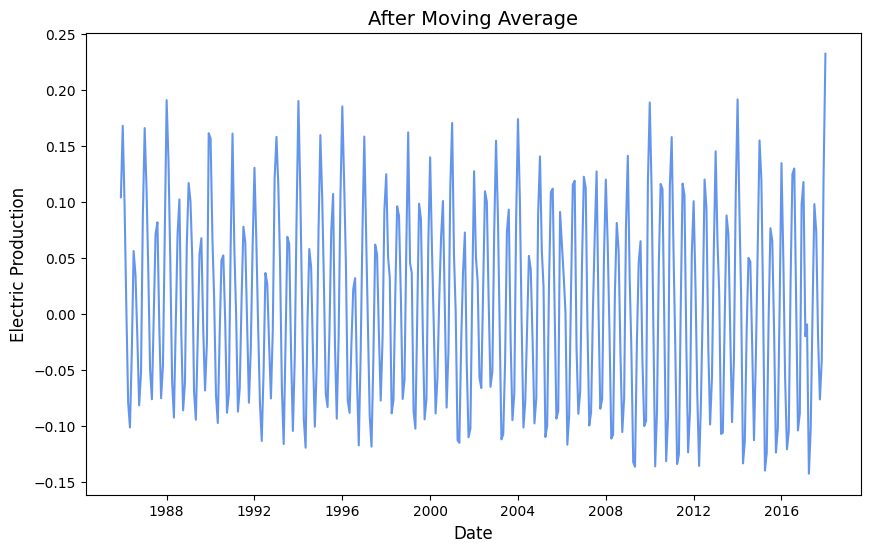

In [ ]:
moving_avg = df_log_scaled.rolling(window=12).mean()
df_log_scaled_ma = df_log_scaled - moving_avg
df_log_scaled_ma.dropna(inplace=True)

plt.figure(figsize = (10,6))
plt.plot(df_log_scaled_ma, color = 'cornflowerblue')
plt.xlabel('Date', size = 12)
plt.ylabel('Electric Production', size = 12)
plt.title("After Moving Average", size = 14)
plt.show()

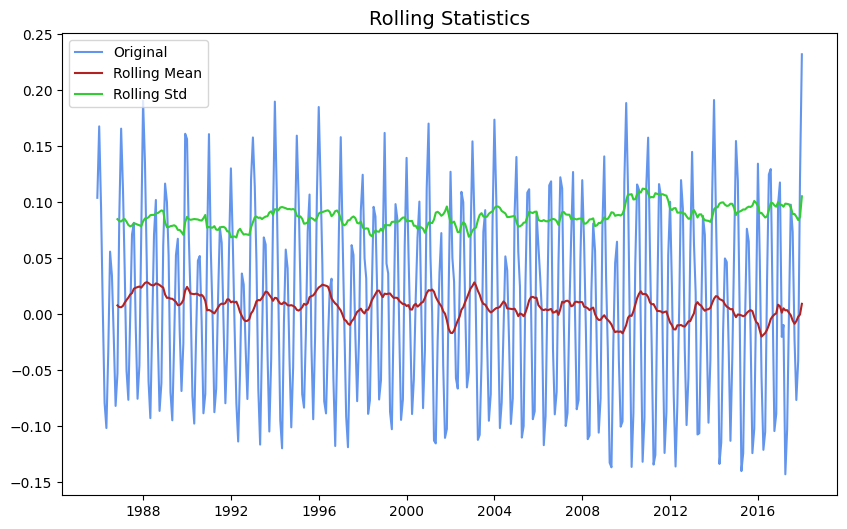


ADF Statistic: -5.212
p-value: 0.0

Critical Values:
1% -3.448
5% -2.869
10% -2.571

Reject null hypothesis, time series is stationary.


In [ ]:
adfuller_test(df_log_scaled_ma,window = 12)

The p-value is very less than the significance level of 0.05 and hence we can reject the null hypothesis and take that the series is stationary.

# Decomposition

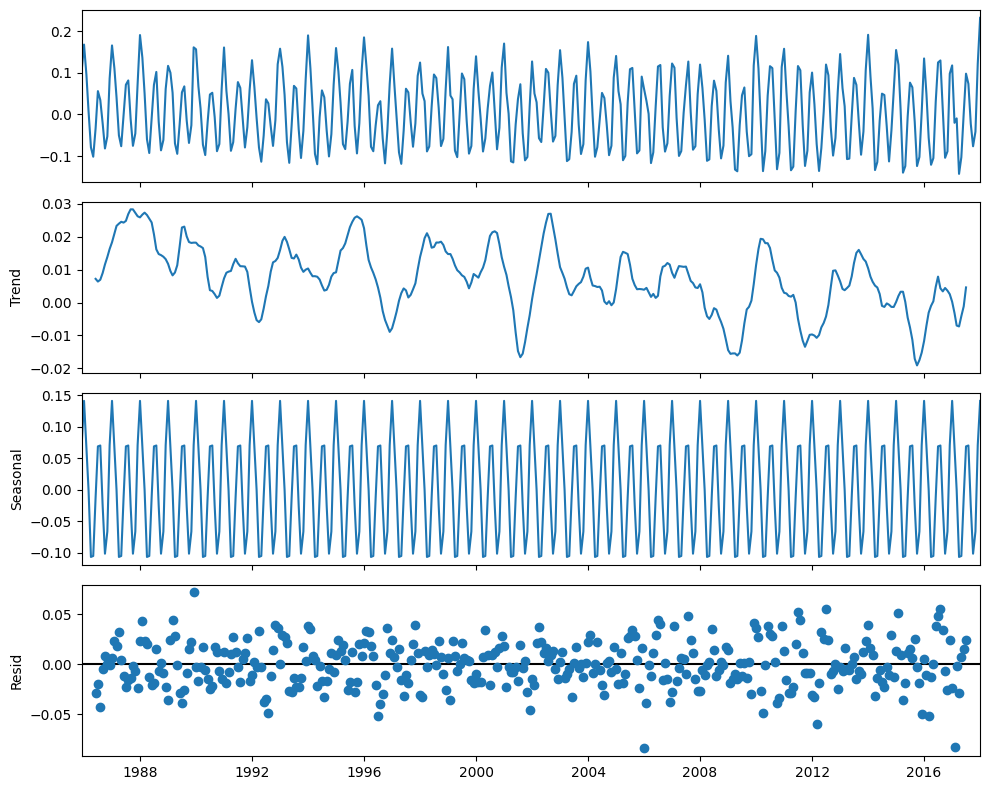

In [ ]:
rcParams['figure.figsize']=10,8

df_seasonal_decompose = seasonal_decompose(df_log_scaled_ma, model='duplicative')
df_seasonal_decompose.plot()
plt.show()

### ACF & PACF

Autocorrelation and partial autocorrelation plots are heavily used in time series analysis and forecasting.

These are plots that graphically summarize the strength of a relationship with an observation in a time series with observations at prior time steps.

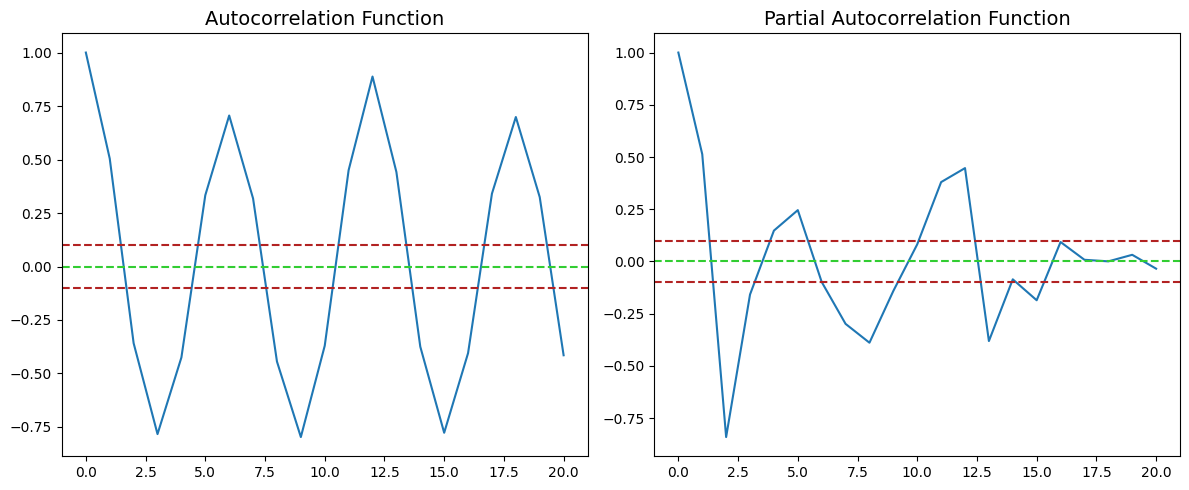

In [ ]:
auto_c_f = acf(df_log_scaled_ma, nlags=20)
partial_auto_c_f = pacf(df_log_scaled_ma, nlags=20, method='ols')

fig, axs = plt.subplots(1, 2, figsize =(12,5))

plt.subplot(121)
plt.plot(auto_c_f)
plt.axhline(y=0, linestyle='--', color='limegreen')
plt.axhline(y=-1.96/np.sqrt(len(df_log_scaled_ma)),linestyle='--', color='firebrick')
plt.axhline(y=1.96/np.sqrt(len(df_log_scaled_ma)),linestyle='--', color='firebrick')
plt.title('Autocorrelation Function', size = 14)

plt.subplot(122)
plt.plot(partial_auto_c_f)
plt.axhline(y=0, linestyle='--', color='limegreen')
plt.axhline(y=-1.96/np.sqrt(len(df_log_scaled_ma)),linestyle='--', color='firebrick')
plt.axhline(y=1.96/np.sqrt(len(df_log_scaled_ma)),linestyle='--', color='firebrick')
plt.title('Partial Autocorrelation Function', size = 14)

plt.tight_layout()

# Forecasting Models

### Autoregression Model

An autoregression model is a linear regression model that uses lagged variables as input variables.


In [ ]:
ar_values = df_log_scaled_ma.values
train = ar_values[1:len(ar_values)-10]
test = ar_values[len(ar_values)-10:]

model = ARIMA(train, order=(2,1,0))
AR_model = model.fit()

predictions = AR_model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
ar_mse = mean_squared_error(test, predictions)
print('AR MSE: ',(round(ar_mse,4)))
ar_mae = mean_absolute_error(test, predictions)
print('AR MAE: ',(round(ar_mae,4)))
ar_rmse = sqrt(mean_squared_error(test, predictions))
print('AR RMSE: ',(round(ar_rmse,4)))

AR MSE:  0.0235
AR MAE:  0.1326
AR RMSE:  0.1534


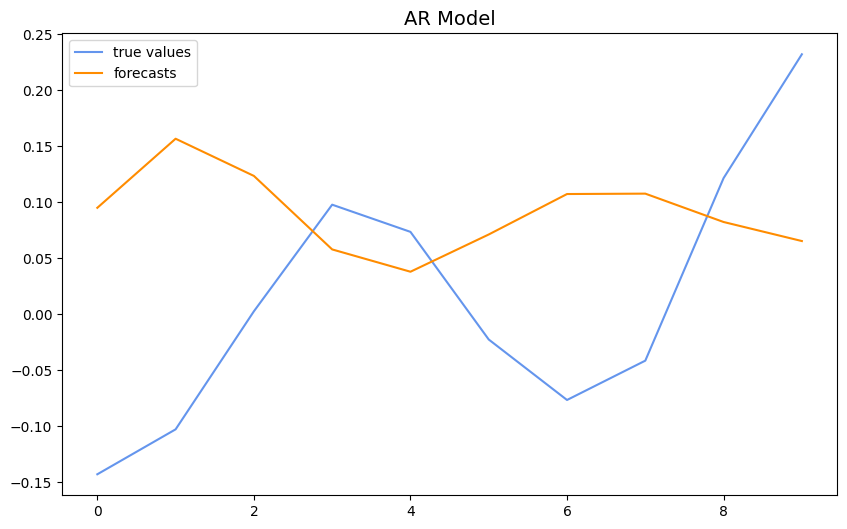

In [ ]:
plt.figure(figsize = (10,6))
plt.plot(test, label = "true values", color = "cornflowerblue")
plt.plot(predictions,label = "forecasts", color='darkorange')
plt.title("AR Model", size = 14)
plt.legend(loc = 'upper left')
plt.show()

## Moving Average Model

In [ ]:
model = ARIMA(train, order=(0,1,2))
MA_model = model.fit()

predictions = MA_model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
ma_mse = mean_squared_error(test, predictions)
print('MA MSE: ',(round(ma_mse,4)))
ma_mae = mean_absolute_error(test, predictions)
print('MA MAE: ',(round(ma_mae,4)))
ma_rmse = sqrt(mean_squared_error(test, predictions))
print('MA RMSE: ',(round(ma_rmse,4)))

MA MSE:  0.0125
MA MAE:  0.0936
MA RMSE:  0.1117


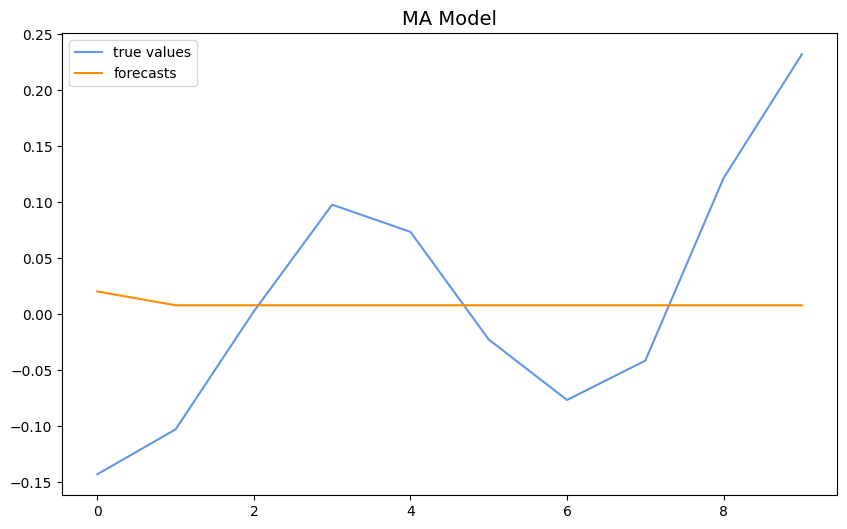

In [ ]:
plt.figure(figsize = (10,6))
plt.plot(test, label = "true values", color = "cornflowerblue")
plt.plot(predictions,label = "forecasts", color='darkorange')
plt.title("MA Model", size = 14)
plt.legend(loc = 'upper left')
plt.show()

## ARIMA Model


In [ ]:
model = ARIMA(train, order=(2,1,2))
ARIMA_model = model.fit()

predictions = ARIMA_model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
arima_mse = mean_squared_error(test, predictions)
print('ARIMA MSE: ',(round(arima_mse,4)))
arima_mae = mean_absolute_error(test, predictions)
print('ARIMA MAE: ',(round(arima_mae,4)))
arima_rmse = sqrt(mean_squared_error(test, predictions))
print('ARIMA RMSE: ',(round(arima_rmse,4)))

ARIMA MSE:  0.0023
ARIMA MAE:  0.043
ARIMA RMSE:  0.0482


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


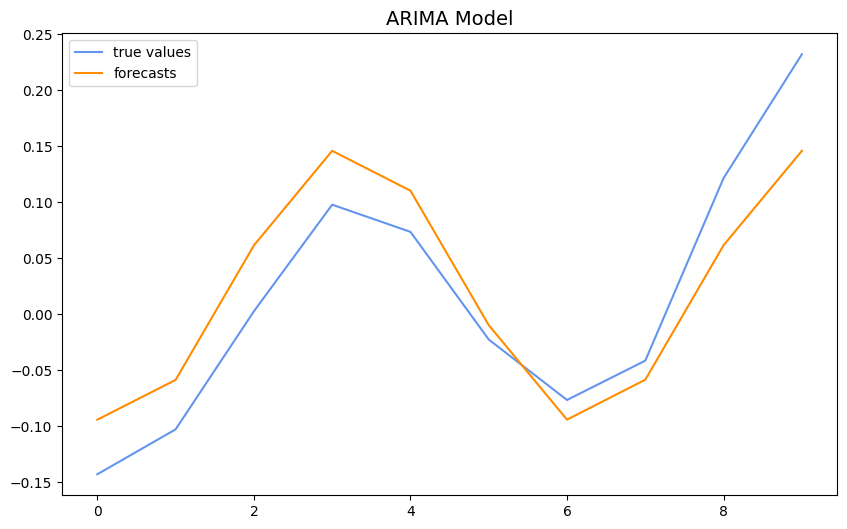

In [ ]:
plt.figure(figsize = (10,6))
plt.plot(test, label = "true values", color = "cornflowerblue")
plt.plot(predictions,label = "forecasts", color='darkorange')
plt.title("ARIMA Model", size = 14)
plt.legend(loc = 'upper left')
plt.show()

In [ ]:
train, test = train_test_split(df['Energy'], test_size=0.2)

autoarima_model = auto_arima(train,
                             start_p=0, max_p=5,
                             start_q=0, max_q=5,
                             d=None, seasonal=False,
                             stepwise=True, suppress_warnings=True,
                             trace=True, error_action="ignore",
                             max_order=None, out_of_sample_size=int(len(test)))
print(autoarima_model.summary())

p, d, q = autoarima_model.order
arima_model = ARIMA(train, order=(p, d, q))
arima_fit = arima_model.fit()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-680.073, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-728.608, Time=0.24 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-792.371, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-682.050, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-790.871, Time=0.39 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.63 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.76 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-794.362, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-792.861, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-851.984, Time=0.27 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-883.805, Time=0.36 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=1.34 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=-914.222, Time=1.35 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-912.006, Time=1.20 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=-1195.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
ar_values = df_log_scaled_ma.values
train = ar_values[1:len(ar_values)-10]
test = ar_values[len(ar_values)-10:]

In [ ]:
errors = pd.DataFrame()
errors["Model"] = [ "Auto Regression", "Moving Average", "ARIMA"]
errors["MSE"] = [ar_mse, ma_mse, arima_mse]
errors = errors.sort_values("MSE", ascending = True, ignore_index = True)
errors.index = errors.Model
del errors["Model"]

def coloring_bg(s, min_, max_, cmap='Reds', low=0, high=0):
    color_range = max_ - min_
    norm = colors.Normalize(min_ - (color_range * low), max_ + (color_range * high))
    normed = norm(s.values)
    c = [colors.rgb2hex(x) for x in plt.cm.get_cmap(cmap)(normed)]
    return ['background-color: %s' % color for color in c]

errors.style.apply(coloring_bg,min_ =errors.min().min(),
               max_ = errors.max().max(), low = 0.1, high = 0.85)



<ipython-input-26-9ab0622d0487>:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  c = [colors.rgb2hex(x) for x in plt.cm.get_cmap(cmap)(normed)]


,MSE
Model,
ARIMA,0.002321
Moving Average,0.012483
Auto Regression,0.023535


In [ ]:
errors = pd.DataFrame()
errors["Model"] = [ "Auto Regression", "Moving Average", "ARIMA"]
errors["MSE"] = [ar_mae, ma_mae, arima_mae]
errors = errors.sort_values("MSE", ascending = True, ignore_index = True)
errors.index = errors.Model
del errors["Model"]

errors.style.apply(coloring_bg,min_ =errors.min().min(),
               max_ = errors.max().max(),cmap="Blues", low = 0.1, high = 0.85)


<ipython-input-26-9ab0622d0487>:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  c = [colors.rgb2hex(x) for x in plt.cm.get_cmap(cmap)(normed)]


,MSE
Model,
ARIMA,0.042988
Moving Average,0.093649
Auto Regression,0.132586


In [ ]:
errors = pd.DataFrame()
errors["Model"] = [ "Auto Regression", "Moving Average", "ARIMA"]
errors["MSE"] = [ar_rmse, ma_rmse, arima_rmse]
errors = errors.sort_values("MSE", ascending = True, ignore_index = True)
errors.index = errors.Model
del errors["Model"]

errors.style.apply(coloring_bg,min_ =errors.min().min(),
               max_ = errors.max().max(),cmap="Oranges", low = 0.1, high = 0.85)

<ipython-input-26-9ab0622d0487>:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  c = [colors.rgb2hex(x) for x in plt.cm.get_cmap(cmap)(normed)]


,MSE
Model,
ARIMA,0.048180
Moving Average,0.111726
Auto Regression,0.153412


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


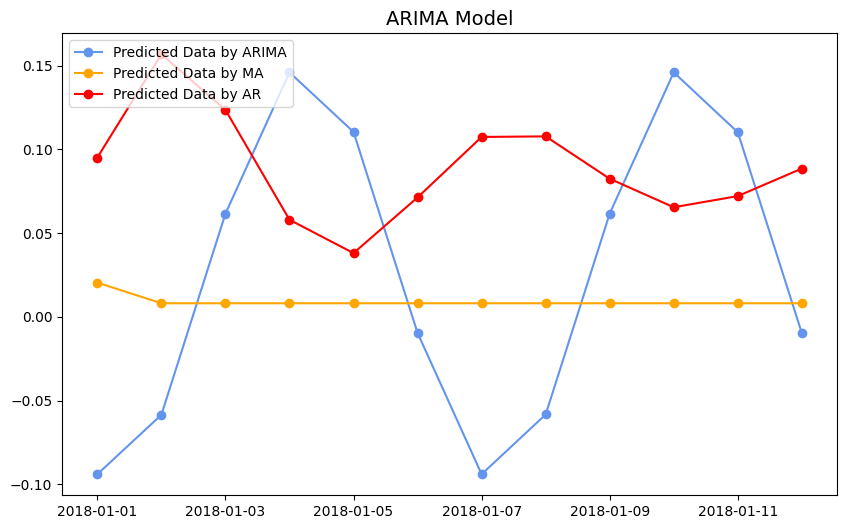

In [ ]:
model = ARIMA(train, order=(2, 1, 2))
ARIMA_model = model.fit()

model = ARIMA(train, order=(0,1,2))
MA_model = model.fit()

model = ARIMA(train, order=(2,1,0))
AR_model = model.fit()

predictions1 = ARIMA_model.predict(start=len(train), end=len(train) + 11, dynamic=False)

predictions2 = MA_model.predict(start=len(train), end=len(train) + 11, dynamic=False)

predictions3= AR_model.predict(start=len(train), end=len(train) + 11, dynamic=False)

next_12_dates = pd.date_range(start=df.index[-1], periods=12, freq=df.index.freq)


plt.figure(figsize=(10, 6))
plt.plot(next_12_dates, predictions1, label='Predicted Data by ARIMA', marker='o', color = "cornflowerblue")
plt.plot(next_12_dates, predictions2, label='Predicted Data by MA', marker='o', color = "orange")
plt.plot(next_12_dates, predictions3, label='Predicted Data by AR', marker='o', color = "red")
plt.title('Next 12 Data Points Prediction')
plt.title("ARIMA Model", size = 14)
plt.legend(loc = 'upper left')
plt.show()


In [ ]:
predictions1=pd.DataFrame(predictions1)
predictions2=pd.DataFrame(predictions2)
predictions3=pd.DataFrame(predictions3)

In [ ]:
predictions1.rename(columns={0:"Energy"},inplace=True)
predictions2.rename(columns={0:"Energy"},inplace=True)
predictions3.rename(columns={0:"Energy"},inplace=True)

In [ ]:
t=df_log_scaled_ma.tail(12)
t

,Energy
Date,
2017-02-01,-0.020110
2017-03-01,-0.009481
2017-04-01,-0.142741
2017-05-01,-0.102643
2017-06-01,0.002691
2017-07-01,0.097842
2017-08-01,0.073579
2017-09-01,-0.022477
2017-10-01,-0.076443


In [ ]:
prediction_df1 = t.append(predictions1,ignore_index=True).tail(24)
prediction_df2 = t.append(predictions2,ignore_index=True).tail(24)
prediction_df3 = t.append(predictions3,ignore_index=True).tail(24)


<ipython-input-82-09e6b55ad2a5>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prediction_df1 = t.append(predictions1,ignore_index=True).tail(24)
<ipython-input-82-09e6b55ad2a5>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prediction_df2 = t.append(predictions2,ignore_index=True).tail(24)
<ipython-input-82-09e6b55ad2a5>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prediction_df3 = t.append(predictions3,ignore_index=True).tail(24)


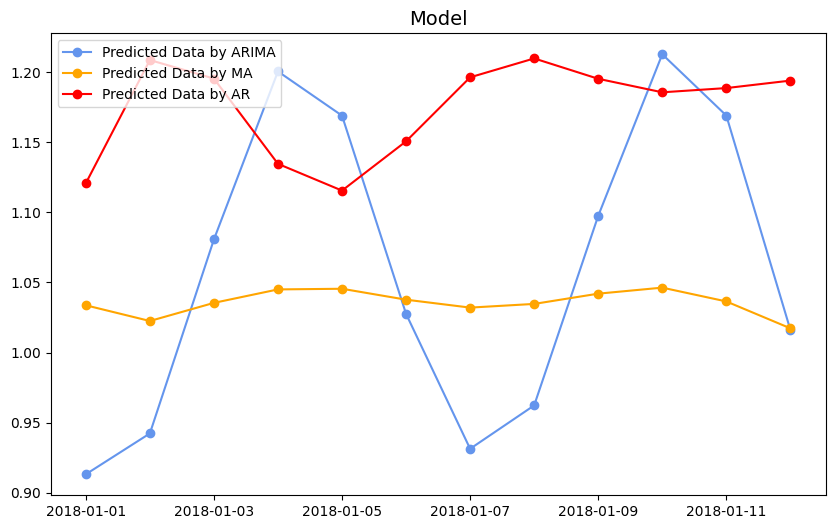

In [ ]:
inv_ma_predictions = prediction_df1.rolling(window=12).mean()
prediction_df1 = prediction_df1 + inv_ma_predictions
original_predictions1 = np.exp(prediction_df1.tail(12))

inv_ma_predictions = prediction_df2.rolling(window=12).mean()
prediction_df2 = prediction_df2 + inv_ma_predictions
original_predictions2 = np.exp(prediction_df2.tail(12))

inv_ma_predictions = prediction_df3.rolling(window=12).mean()
prediction_df3 = prediction_df3 + inv_ma_predictions
original_predictions3 = np.exp(prediction_df3.tail(12))


plt.figure(figsize=(10, 6))
plt.plot(next_12_dates, original_predictions1, label='Predicted Data by ARIMA', marker='o', color = "cornflowerblue")
plt.plot(next_12_dates, original_predictions2, label='Predicted Data by MA', marker='o', color = "orange")
plt.plot(next_12_dates, original_predictions3, label='Predicted Data by AR', marker='o', color = "red")
plt.title('Next 12 Data Points Prediction')
plt.title("Model", size = 14)
plt.legend(loc = 'upper left')
plt.show()



/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
<ipython-input-87-7cf7f2fecdfb>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prediction_df = t.append(predictions1,ignore_index=True).tail(24)


Global Model Forecast:
[-0.00133253 -0.00329723 -0.00135054 -0.00327934 -0.00136831 -0.00326169
 -0.00138584 -0.00324429 -0.00140312 -0.00322713 -0.00142016 -0.00321021]


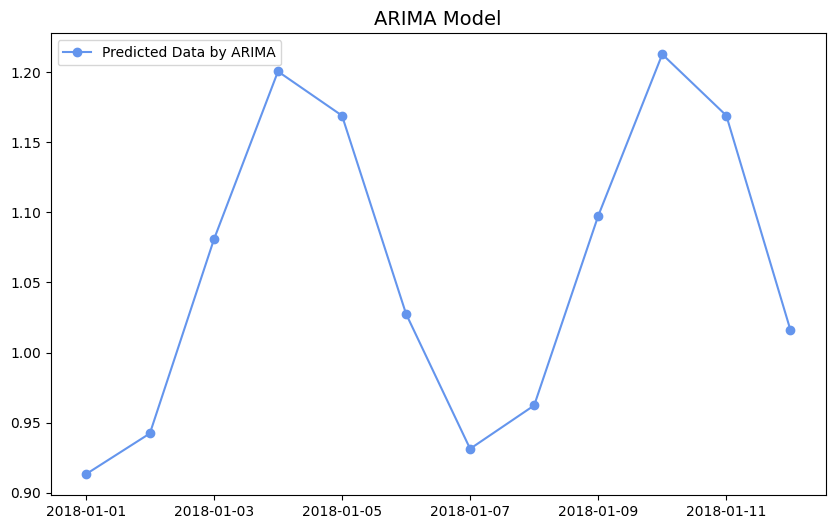

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

# Simulated time series data for multiple clients
num_clients = 3
client_data = {}

for i in range(num_clients):
    client_data[i] = df.sample(n=150,replace = True)


# Define a simple function for local ARIMA model training
def train_local_arima(data):
    df_log_scaled = data
    df_log_scaled['Energy'] = boxcox(df_log_scaled['Energy'], lmbda=0.0)

    moving_avg = df_log_scaled.rolling(window=12).mean()
    df_log_scaled_ma = df_log_scaled - moving_avg
    df_log_scaled_ma.dropna(inplace=True)

    auto_c_f = acf(df_log_scaled_ma, nlags=20)
    partial_auto_c_f = pacf(df_log_scaled_ma, nlags=20, method='ols')

    ar_values = df_log_scaled_ma.values
    train = ar_values[1:len(ar_values)-10]
    test = ar_values[len(ar_values)-10:]

    model = ARIMA(train, order=(2,1,2))
    ARIMA_model = model.fit()
    return ARIMA_model

local_models = {}
for client_id in range(num_clients):
    local_models[client_id] = train_local_arima(client_data[client_id])

global_forecast = np.mean([model.predict(start=len(client_data[0]), end=len(client_data[0]) + 11) for model in local_models.values()], axis=0)

print("Global Model Forecast:")
print(global_forecast)


predictions=pd.DataFrame(global_forecast)
predictions.rename(columns={0:"Energy"},inplace=True)
t=df_log_scaled_ma.tail(12)
prediction_df = t.append(predictions1,ignore_index=True).tail(24)
inv_ma_predictions = prediction_df.rolling(window=12).mean()
prediction_df = prediction_df + inv_ma_predictions
original_predictions = np.exp(prediction_df.tail(12))

plt.figure(figsize=(10, 6))
plt.plot(next_12_dates, original_predictions, label='Predicted Data by ARIMA', marker='o', color = "cornflowerblue")
plt.title('Next 12 Data Points Prediction')
plt.title("ARIMA Model", size = 14)
plt.legend(loc = 'upper left')
plt.show()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Global Model Forecast:
[1.3725204 1.3725204 1.3725204 1.3725204 1.3725204 1.3725204 1.3725204
 1.3725204 1.3725204 1.3725204 1.3725204 1.3725204]


<ipython-input-86-aa9e84abc7de>:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  prediction_df = t.append(predictions1,ignore_index=True).tail(24)


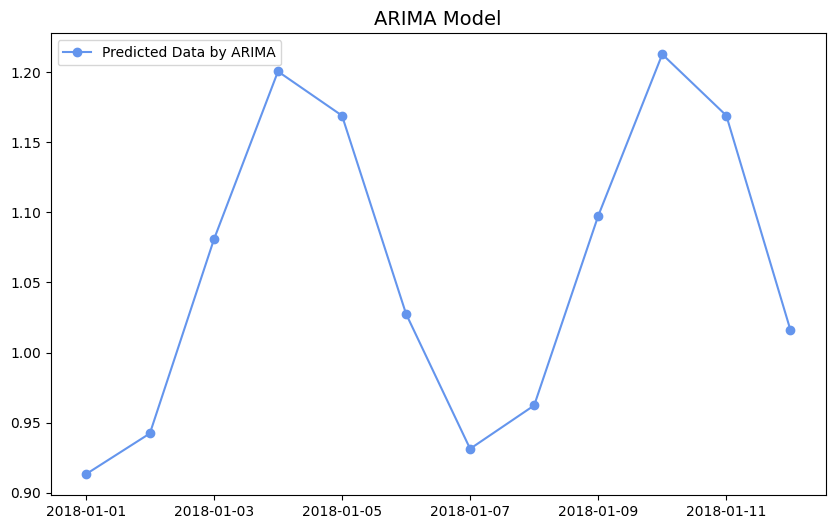

In [ ]:
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

# Simulated time series data for multiple teachers
num_teachers = 5
teacher_data = {}
for i in range(num_teachers):
    teacher_data[i] = df.sample(n=150,replace = True)

# Define a simple function for training a local ARIMA model
def train_local_arima(data):
    df_log_scaled = data
    df_log_scaled['Energy'] = boxcox(df_log_scaled['Energy'], lmbda=0.0)

    moving_avg = df_log_scaled.rolling(window=12).mean()
    df_log_scaled_ma = df_log_scaled - moving_avg
    df_log_scaled_ma.dropna(inplace=True)

    auto_c_f = acf(df_log_scaled_ma, nlags=20)
    partial_auto_c_f = pacf(df_log_scaled_ma, nlags=20, method='ols')

    ar_values = df_log_scaled_ma.values
    train = ar_values[1:len(ar_values)-10]
    test = ar_values[len(ar_values)-10:]

    model = ARIMA(train, order=(2,1,2))
    ARIMA_model = model.fit()
    return ARIMA_model

# Simulate local training for each teacher
local_models = {}
for teacher_id in range(num_teachers):
    local_models[teacher_id] = train_local_arima(teacher_data[teacher_id])

# Perturb the outputs to introduce noise (for simplicity, use Laplace noise)
privacy_budget = 1.0  # Adjust privacy budget as needed
epsilon = privacy_budget / num_teachers
perturbed_outputs = {}
for teacher_id, model in local_models.items():
    perturbed_output = model.forecast(steps=10) + np.random.laplace(scale=1.0 / epsilon, size=10)
    perturbed_outputs[teacher_id] = perturbed_output

# Aggregate the perturbed outputs to train the student model
student_data = np.mean(list(perturbed_outputs.values()), axis=0)
student_model = ARIMA(student_data, order=(2, 1,2))
student_arima_model = student_model.fit()

global_forecast = student_arima_model.predict(start=len(teacher_data[0]), end=len(teacher_data[0]) + 11)


print("Global Model Forecast:")
print(global_forecast)


predictions=pd.DataFrame(global_forecast)
predictions.rename(columns={0:"Energy"},inplace=True)
t=df_log_scaled_ma.tail(12)
prediction_df = t.append(predictions1,ignore_index=True).tail(24)
inv_ma_predictions = prediction_df.rolling(window=12).mean()
prediction_df = prediction_df + inv_ma_predictions
original_predictions = np.exp(prediction_df.tail(12))

plt.figure(figsize=(10, 6))
plt.plot(next_12_dates, original_predictions, label='Predicted Data by ARIMA', marker='o', color = "cornflowerblue")
plt.title('Next 12 Data Points Prediction')
plt.title("ARIMA Model", size = 14)
plt.legend(loc = 'upper left')
plt.show()

# The student model is now trained with privacy guarantees
